<img src="https://gist.githubusercontent.com/nesnoj/6ee605cd3494fa6e3e848385c4afbe19/raw/a883b1bdc69c0c5bbb0b00ba92f43033aa86ec64/dingo_model.png" alt="DINGO Model" width="800"  align="center">

In [1]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn

In [2]:
import osmnx as ox

import networkx as nx 

import pandas as pd
from sqlalchemy import func              
from geoalchemy2.shape import to_shape 


from shapely.geometry import Point, Polygon, LineString



import folium

In [3]:
from config.config_lv_grids_osm import get_config_osm
from config.db_conn_local import create_session_osm 

from grid.lv_grid.routing import build_graph_from_ways, \
get_location_substation_at_pi, subdivide_graph_edges

from grid.lv_grid.parameterization import parameterize_by_load_profiles
from grid.lv_grid.clustering import get_n_cluster, cluster_k_means

from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, \
get_convex_hull_from_points

ImportError: cannot import name 'get_n_cluster' from 'grid.lv_grid.clustering' (C:\Users\Robert\anaconda3\envs\ox\Lib\site-packages\ding0\grid\lv_grid\clustering.py)

#### SET DING0 SETTINGS

In [ ]:
# TODO set in config file
ding0_default=False
retain_all=True

In [ ]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [ ]:
%%time

# load graph by ding0
graph_subdiv, geo_load_area, buildings_w_a, buildings_wo_a, amenities_ni_Buildings, buildings_w_loads_df \
= nd.import_mv_grid_districts(session, ding0_default, mv_grid_districts_no=mv_grid_districts)

In [ ]:
%%time


# TODO: PROJECT TO GET DIST
graph_subdiv_4326 = ox.project_graph(graph_subdiv, to_crs='epsg:4326')

In [ ]:
X = buildings_w_loads_df['x'].tolist()
Y = buildings_w_loads_df['y'].tolist()

buildings_w_loads_df['nn'], buildings_w_loads_df['nn_dist'] = ox.nearest_nodes(graph_subdiv_4326, X, Y, return_dist=True)


In [ ]:
buildings_w_loads_df.head(3)

In [ ]:
street_loads = buildings_w_loads_df.groupby(['nn']).capacity.sum().reset_index().set_index('nn')
street_load_nodes = street_loads.index.tolist()


In [ ]:
len(street_load_nodes), len(buildings_w_loads_df)

In [ ]:
digraph = nx.MultiGraph(graph_subdiv_4326)
digraph = digraph.to_directed()


In [ ]:
nc = ["r" if ox.simplification._is_endpoint(digraph, node) else "w" for node in digraph.nodes()]
fig, ax = ox.plot_graph(digraph, node_color=nc)

In [ ]:
# keep only street_load_nodes and endpoints

endpoints = [n for n in digraph.nodes if ox.simplification._is_endpoint(digraph, n, strict=True)]
nodes_to_keep = list(set(endpoints + street_load_nodes))

In [ ]:
nc = ["r" if node in nodes_to_keep else "w" for node in digraph.nodes()]
fig, ax = ox.plot_graph(digraph, node_color=nc)

In [ ]:
buildings_w_loads_df['nn_coords'] = buildings_w_loads_df['nn'].apply(lambda row : Point(digraph.nodes[row]['x'], digraph.nodes[row]['y']))

In [ ]:
import geopandas  # to plot buildings

In [ ]:
# to plot a gdf
buildings_w_loads_gdf = geopandas.GeoDataFrame(buildings_w_loads_df, geometry='geometry')

In [ ]:
# modified osmnx function (extended by nodes_to_keep)
# feststellen welche knoten behalten und welche weg. build paths.

def _get_paths_to_simplify(G, nodes_to_keep, strict=True):
    """
    Generate all the paths to be simplified between endpoint nodes.
    The path is ordered from the first endpoint, through the interstitial nodes,
    to the second endpoint.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    strict : bool
        if False, allow nodes to be end points even if they fail all other rules
        but have edges with different OSM IDs
    Yields
    ------
    path_to_simplify : list
    """
    
    
    # for each endpoint node, look at each of its successor nodes
    for endpoint in nodes_to_keep:
        for successor in G.successors(endpoint):
            if successor not in nodes_to_keep:
                # if endpoint node's successor is not an endpoint, build path
                # from the endpoint node, through the successor, and on to the
                # next endpoint node
                yield ox.simplification._build_path(G, endpoint, successor, nodes_to_keep)

In [ ]:
# modified osmnx function (extended by nodes_to_keep)

# del paths from above and build new graph

def simplify_graph(G, nodes_to_keep, strict=True, remove_rings=True):
    """
    Simplify a graph's topology by removing interstitial nodes.
    Simplifies graph topology by removing all nodes that are not intersections
    or dead-ends. Create an edge directly between the end points that
    encapsulate them, but retain the geometry of the original edges, saved as
    a new `geometry` attribute on the new edge. Note that only simplified
    edges receive a `geometry` attribute. Some of the resulting consolidated
    edges may comprise multiple OSM ways, and if so, their multiple attribute
    values are stored as a list.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    strict : bool
        if False, allow nodes to be end points even if they fail all other
        rules but have incident edges with different OSM IDs. Lets you keep
        nodes at elbow two-way intersections, but sometimes individual blocks
        have multiple OSM IDs within them too.
    remove_rings : bool
        if True, remove isolated self-contained rings that have no endpoints
    Returns
    -------
    G : networkx.MultiDiGraph
        topologically simplified graph, with a new `geometry` attribute on
        each simplified edge
    """
    if "simplified" in G.graph and G.graph["simplified"]:  # pragma: no cover
        raise Exception("This graph has already been simplified, cannot simplify it again.")

    #utils.log("Begin topologically simplifying the graph...")
    print("Begin topologically simplifying the graph...")

    # define edge segment attributes to sum upon edge simplification
    attrs_to_sum = {"length", "travel_time"}

    # make a copy to not mutate original graph object caller passed in
    G = G.copy()
    initial_node_count = len(G)
    initial_edge_count = len(G.edges)
    all_nodes_to_remove = []
    all_edges_to_add = []

    # generate each path that needs to be simplified
    for path in _get_paths_to_simplify(G, nodes_to_keep, strict=strict):

        # add the interstitial edges we're removing to a list so we can retain
        # their spatial geometry
        path_attributes = dict()
        for u, v in zip(path[:-1], path[1:]):

            # there should rarely be multiple edges between inter_get_paths_to_simplify(G, nodes_to_keep, strict=True):stitial nodes
            # usually happens if OSM has duplicate ways digitized for just one
            # street... we will keep only one of the edges (see below)
            edge_count = G.number_of_edges(u, v)
            if edge_count != 1:
                #utils.log(f"Found {edge_count} edges between {u} and {v} when simplifying")
                print(f"Found {edge_count} edges between {u} and {v} when simplifying")

            # get edge between these nodes: if multiple edges exist between
            # them (see above), we retain only one in the simplified graph
            edge_data = G.edges[u, v, 0]
            
            edge_data.pop('geometry', None) ### NECESSARY FOR THIS PARTIC. CASE (PAUL: if geometry in attributes)
            
            for attr in edge_data:
                if attr in path_attributes:
                    # if this key already exists in the dict, append it to the
                    # value list
                    path_attributes[attr].append(edge_data[attr])
                else:
                    # if this key doesn't already exist, set the value to a list
                    # containing the one value
                    path_attributes[attr] = [edge_data[attr]]

        # consolidate the path's edge segments' attribute values
        for attr in path_attributes:
            if attr in attrs_to_sum:
                # if this attribute must be summed, sum it now
                path_attributes[attr] = sum(path_attributes[attr])
            elif len(set(path_attributes[attr])) == 1:
                # if there's only 1 unique value in this attribute list,
                # consolidate it to the single value (the zero-th):
                path_attributes[attr] = path_attributes[attr][0]
            else:
                # otherwise, if there are multiple values, keep one of each
                path_attributes[attr] = list(set(path_attributes[attr]))

        # construct the new consolidated edge's geometry for this path
        path_attributes["geometry"] = LineString(
            [Point((G.nodes[node]["x"], G.nodes[node]["y"])) for node in path]
        )

        # add the nodes and edge to their lists for processing at the end
        all_nodes_to_remove.extend(path[1:-1])
        all_edges_to_add.append(
            {"origin": path[0], "destination": path[-1], "attr_dict": path_attributes}
        )

    # for each edge to add in the list we assembled, create a new edge between
    # the origin and destination
    for edge in all_edges_to_add:
        G.add_edge(edge["origin"], edge["destination"], **edge["attr_dict"])

    # finally remove all the interstitial nodes between the new edges
    G.remove_nodes_from(set(all_nodes_to_remove))

    if remove_rings:
        # remove any connected components that form a self-contained ring
        # without any endpoints
        wccs = nx.weakly_connected_components(G)
        nodes_in_rings = set()
        for wcc in wccs:
            if not any(ox.simplification._is_endpoint(G, n) for n in wcc):
                nodes_in_rings.update(wcc)
        G.remove_nodes_from(nodes_in_rings)

    # mark graph as having been simplified
    G.graph["simplified"] = True

    msg = (
        f"Simplified graph: {initial_node_count} to {len(G)} nodes, "
        f"{initial_edge_count} to {len(G.edges)} edges"
    )
    #utils.log(msg)
    print(msg)
    return G

In [ ]:
simp_graph = simplify_graph(digraph, nodes_to_keep)

In [4]:
# plot subdivided graph
simp_graph = ox.utils_graph.get_undirected(simp_graph)

fig, ax = ox.plot_graph(simp_graph, show=False, close=False)
fig.set_figheight(13)

print('old:', graph_subdiv.number_of_nodes())
print('new:', simp_graph.number_of_nodes())

NameError: name 'simp_graph' is not defined

In [46]:
building_graph = simp_graph.copy()

for b_id, b_data in buildings_w_loads_df.iterrows():
    building_graph.add_node(b_id, x=b_data['raccordement_building'].x, y=b_data['raccordement_building'].y)
    line=LineString([b_data['raccordement_building'], b_data['nn_coords']])
    building_graph.add_edge(b_id, b_data['nn'], geometry=line, length=line.length)


old: 162
new: 262


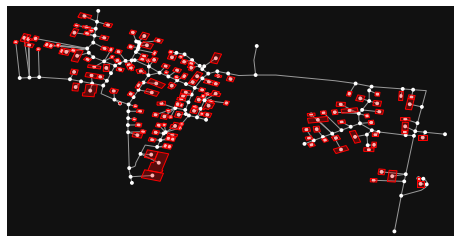

In [47]:
# plot building graph
fig, ax = ox.plot_graph(building_graph, show=False, close=False)
fig.set_figheight(13)
buildings_w_loads_gdf.plot(ax=ax, edgecolor=(1,0,0,1), facecolor=(1,0,0,.3))

print('old:', digraph.number_of_nodes())
print('new:', building_graph.number_of_nodes())


In [17]:
nodes, edges = ox.graph_to_gdfs(digraph)


In [19]:
m = folium.Map([geo_load_area.centroid.y, geo_load_area.centroid.x], zoom_start=16)
folium.GeoJson(geo_load_area).add_to(m)
folium.GeoJson(edges).add_to(m)
folium.GeoJson(nodes).add_to(m)
m

In [13]:
from pyproj import Proj, transform


In [33]:
def transform_to_lon_lat(x1,y1):
    inProj = Proj(init='epsg:3035')
    outProj = Proj(init='epsg:4326')
    x2,y2 = transform(inProj,outProj,x1,y1)
    return x2,y2

In [ ]:
# TODO REPLACE DEPRECATED ABOVE WITH TRANSFORMER AND ENSURE GOOD RUNTIME

In [48]:
from pyproj import Transformer

In [50]:
transformer = Transformer.from_crs(3035, 3857, always_xy=True)

In [56]:
%%time

nodes['lon'], nodes['lat'] = transform_to_lon_lat(nodes['x'],nodes['y'])

C:\Users\Robert\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Robert\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\Robert\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

Wall time: 600 ms


In [57]:
nodes

,x,y,lon,lat,geometry
osmid,,,,,
329334526,4.282466e+06,2.732307e+06,9.486881,47.703176,POINT (4282465.613 2732307.093)
331517278,4.282464e+06,2.732317e+06,9.486856,47.703262,POINT (4282463.777 2732316.628)
329334521,4.282368e+06,2.732255e+06,9.485590,47.702699,POINT (4282368.259 2732254.699)
331519841,4.282486e+06,2.732289e+06,9.487157,47.703015,POINT (4282486.219 2732289.038)
331517282,4.282464e+06,2.732332e+06,9.486853,47.703405,POINT (4282463.682 2732332.486)
...,...,...,...,...,...
614390617701,4.282116e+06,2.732266e+06,9.482235,47.702784,POINT (4282116.416 2732265.951)
614390618601,4.282081e+06,2.732231e+06,9.481773,47.702465,POINT (4282081.427 2732230.693)
340448086901,4.282003e+06,2.732537e+06,9.480702,47.705218,POINT (4282003.081 2732537.180)


In [ ]:
# todo check if truncate creates subgrpahs
# if len(subgraphs) > 1:
    # there are unconnected subgraphs
    # then for each subgraph
        # cluserting
        # for each cluster
            # build lv_grid_district

### Clustering

In [27]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

In [29]:
n_clusters

3

### Update and add _districts

In [30]:
for i in range(n_clusters):
    
    print(len(buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==i)]))


99
85
79


In [28]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,area,number_households,x,y,geometry,raccordement,nn,nn_dist,Cluster
osm_id,,,,,,,,,,,
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132,0
144020300,public_building,244.695822,2113.09,0.8125,9.438239,47.675506,"POLYGON ((9.437905999999998 47.67551250001376,...",POINT (9.438238891069723 47.67550616796044),1576023053,34.831012,0
144023114,school,102.108142,1641.61,0.552632,9.438521,47.673818,"POLYGON ((9.438203599999998 47.67375600001416,...",POINT (9.438521488700175 47.67381754064048),68844093,33.677840,0
314909001,residential,1.246721,100,0.72973,9.43711,47.674319,"POLYGON ((9.4370154 47.67431780001401, 9.43711...",POINT (9.437109750000001 47.67431900001404),2080880814,14.638173,0
314909020,house,1.102239,100,0.645161,9.437548,47.674401,"POLYGON ((9.4374646 47.674413400014, 9.4375446...",POINT (9.437548450000001 47.67440130001403),314975344,15.374000,0
...,...,...,...,...,...,...,...,...,...,...,...
314913916,residential,2.904399,100,1.7,9.436301,47.672468,"POLYGON ((9.436173800000001 47.67246730001447,...",POINT (9.436301343479869 47.67246766666069),311379901,30.431139,0
338514542,school,407.558658,6552.39,0.594203,9.438414,47.673881,"POLYGON ((9.437957300000001 47.67387860001414,...",POINT (9.438414351486788 47.67388107322754),68844093,31.901109,0
401560706,residential,1.102239,100,0.645161,9.43769,47.674448,"POLYGON ((9.4376228 47.674467300014, 9.4377058...",POINT (9.437690147469656 47.67444791593603),314975344,27.030240,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

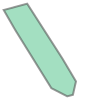

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

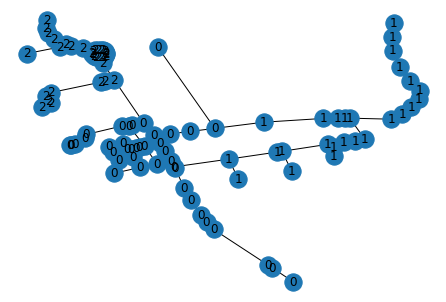

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

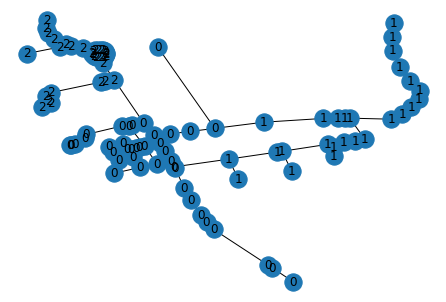

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)